<a href="https://colab.research.google.com/github/pravincoder/Convolution-from-scratch/blob/main/examples/LeNet5_with_MNIST_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

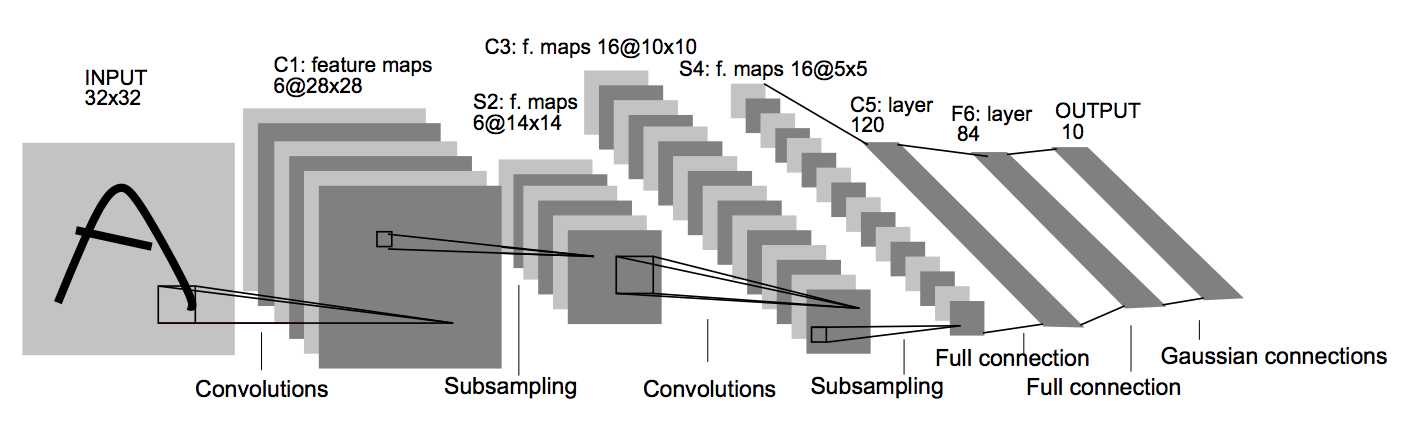

In [7]:
# Lib
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook

print(torch.cuda.is_available())

True


In [8]:
# LeNet 5
class LeNet5(nn.Module):
  def __init__(self,input_channels=1,classes=10): #input_channels=1 for grey scale img , 3 for RGB
    super().__init__()
    self.c1 = nn.Conv2d(in_channels=input_channels,out_channels=6,kernel_size=5,stride=1,padding=2)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
    self.conv3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1,padding=0)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1=nn.Linear(in_features=120,out_features=84)
    self.fc2=nn.Linear(in_features=84,out_features=classes)

  def forward(self,img):
    # img Shape:[batch,1,28,28]
    x = self.c1(img)
    # x shape :[batch,6,28,28]
    x = self.relu(self.maxpool(x)) # SubSampling 1
    # x Shape:[batch,6,14,14]
    x = self.conv2(x)
    # x shape :[batch,6,10,10]
    x = self.relu(self.maxpool(x)) # SubSampling 2
    # x shape :[batch,16,5,5]
    x = self.relu(self.conv3(x))
    # x shape : [batch,120,1,1]
    x = torch.flatten(x,1)
    # x shape :[batch,120]
    x = self.relu(self.fc1(x))
    # x shape : [batch,84]
    x = self.fc2(x)
    # x shape : [batch,10]
    return x

    return x
l = LeNet5()
l(torch.rand(16,1,28,28)).shape




torch.Size([16, 10])

In [9]:
# hyperParameters
model = LeNet5()
lr= 1e-4
epochs = 25
batch = 32
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=lr)

In [10]:
def Dataset(batch_size):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))
                ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)

    # Split dataset into train and validation set
    trainset, valset = torch.utils.data.random_split(trainset, [57500, 2500])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)

    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False)

    return trainloader, valloader, testloader

In [11]:
# Train, validation , test function
class Model:
    def __init__(self, model, learning_rate, device):
        self.model = model
        self.lr = learning_rate
        self.loss = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.device = device

    def batch_accuracy(self, output, target):
        # output shape: [batch, 10]
        output = nn.functional.softmax(output, dim=1)
        output = output.argmax(1)
        acc = torch.sum(output==target) / output.shape[0]
        return acc.cpu()*100

    def train_step(self, dataset):
        self.model.train()
        batch_loss = []
        batch_acc = []
        for batch in dataset:
            inputs = batch[0].to(self.device)
            targets = batch[1].to(self.device)
            self.opt.zero_grad()

            outputs = self.model(inputs)

            loss = self.loss(outputs, targets)
            loss.backward()
            self.opt.step()
            batch_loss.append(loss.item())
            batch_acc.append(self.batch_accuracy(outputs,targets))

        self.train_loss.append(np.mean(batch_loss))
        self.train_acc.append(np.mean(batch_acc))

    def validation_step(self, dataset):
        self.model.eval()
        batch_loss = []
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = batch[1].to(self.device)

                outputs = self.model(inputs)

                loss = self.loss(outputs, targets)
                batch_loss.append(loss.item())
                batch_acc.append(self.batch_accuracy(outputs,targets))

        self.val_loss.append(np.mean(batch_loss))
        self.val_acc.append(np.mean(batch_acc))

    def test_step(self, dataset):
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = batch[1].to(self.device)

                outputs = self.model(inputs)
                batch_acc.append(self.batch_accuracy(outputs,targets))

        print("Accuracy : ", np.mean(batch_acc), "%")


In [12]:
# Training
epochs = 15
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-4
batch = 32
lenet5 = LeNet5().to(device)
train_loader, val_loader, test_loader = Dataset(batch)
model = Model(lenet5, learning_rate, device)
for epoch in tqdm_notebook(range(epochs), desc='Epoch'):
    model.train_step(train_loader)
    model.validation_step(val_loader)
model.test_step(test_loader)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy :  98.65215 %


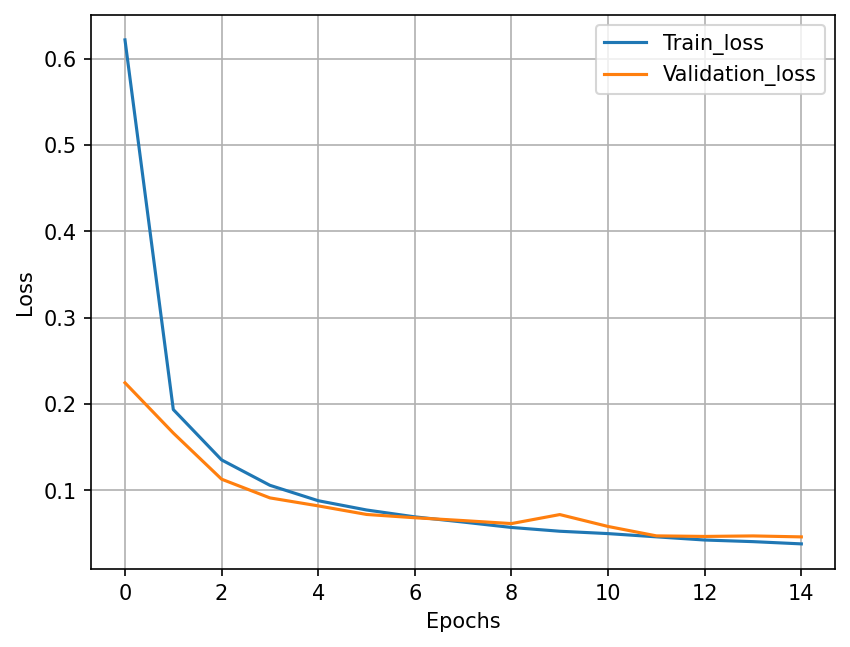

In [14]:
plt.figure(dpi=150)
plt.grid()
plt.plot(model.train_loss)
plt.plot(model.val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train_loss','Validation_loss'])
plt.savefig("Accuracy.png")